In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

# Black-Scholes Model Formulation

The Black-Scholes model describes the dynamics of the underlying asset price, $S_t$, through the following stochastic differential equation (SDE) :

$$
dS_t = r S_t dt + \sigma S_t dW_t
$$

Where:
- $S_t$ is the price of the asset at time $t$.
- $r$ is the risk-free interest rate.
- $\sigma$ is the volatility of the asset price.
- $W_t$ represents a standard Brownian motion.

From this equation, we can derive the explicit solution for the asset price at time $t$ :

$$
S_t = S_0 \exp\left( \left( r - \frac{\sigma^2}{2} \right) t + \sigma W_t \right)
$$

Where:
- $S_0$ is the initial price of the asset at time $t = 0$.


In [4]:
class asset:
    def __init__(self, S0, r, sigma, T, n_steps):
        """
        Initializes the Asset object for simulating price paths using the Black-Scholes model.

        Parameters:
            S0 (float): Initial asset price.
            r (float): Risk-free interest rate.
            sigma (float): Volatility of the asset.
            T (float): Time to maturity (in years).
            n_steps (int): Number of time steps in the simulation.
        """
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.T = T
        self.n_steps = n_steps
        self.delta_t = T / n_steps

    def brownian_paths(self, noise):
        """
        Generates Brownian paths based on input noise and time increments.

        Parameters:
            noise (np.ndarray): Array of random noise values for the Brownian motion.

        Returns:
            np.ndarray: Cumulative sum of Brownian increments, representing the Brownian paths.
        """
        t = np.linspace(0, self.T, self.n_steps)
        dB = np.zeros(self.n_steps)
        dB[1:] = np.sqrt(t[1:] - t[:-1]) * noise[1:]
        return np.cumsum(dB)

    def black_and_scholes_paths(self):
        """
        Simulates asset price paths under the Black-Scholes model.

        Returns:
            np.ndarray: Array of simulated asset prices over time.
        """
        noise = np.random.normal(0, 1, self.n_steps)
        W = self.brownian_paths(noise)
        t = np.linspace(0, self.T, self.n_steps)
        S = self.S0 * np.exp((self.r - 0.5 * self.sigma ** 2) * t + self.sigma * W)
        return S

# Replication Strategy with Transaction Costs and Leland Correction

In an idealized setting, a replication strategy can be represented by the following dynamics:

$$
dV_t = \delta_t \, dS_t + (V_t - \delta_t S_t) \, \frac{dB_t}{B_t}
$$

which can be discretized as:

$$
V_{t + 1} = V_t + \delta_t (S_{t + 1} - S_t) + (V_t - \delta_t S_t) \, r \, \Delta t
$$

In this expression:
- $V_t$ represents the portfolio value at time $t$.
- $\delta_t$ is the number of shares held in the asset $S$ to replicate the option.
- $r$ is the risk-free rate.
- $\Delta t$ the time step interval.
  
This approach assumes a continuous, cost-free adjustment of the portfolio's position to replicate the option. However, in the real world, adjusting our portfolio at each time step incurs **transaction costs**, which we need to account for.

## Transaction Costs in Portfolio Rebalancing

Each time the portfolio is rebalanced, we experience a cost due to the bid-ask spread. The cumulative cost at each rebalancing step $t$ can be represented as:

$$
C_t = 2k S_t |\delta_t - \delta_{t - 1}|
$$

where:
- $2k$ represents the bid-ask spread.
- $S_t$ is the asset price at time $t$.
- $\delta_t - \delta_{t - 1}$ denotes the change in position, reflecting the quantity of shares bought or sold.

Frequent reallocation results in accumulated transaction costs, leading to a discrepancy between the replication portfolio value at maturity $T$ and the theoretical option price.

## Adjusting Volatility for Transaction Costs: The Leland Correction

To mitigate the impact of transaction costs on the replication strategy, we use an adjusted volatility, often referred to as the **Leland volatility correction**. This correction modifies the volatility $\sigma$ to better approximate the true option price at maturity, incorporating the effect of the bid-ask spread.

In practice, this leads to selling the contract at a higher price to compensate for the losses incurred by the portfolio reallocation.

The adjusted volatility $\tilde{\sigma}$ is given by:

$$
\tilde{\sigma}^2 = \sigma^2 \left(1 + \frac{2k}{\sigma} \sqrt{\frac{2}{\pi \Delta_t}}\right)
$$

where:
- $\Delta_t$ represents the time step interval ie. how many time we realocate our portofolio (every day, every 2 days, every week...).
- $\sigma$ is the original volatility of the asset.

By using $\tilde{\sigma}$, our replication strategy more closely aligns the portfolio value at maturity with the actual option price, compensating for the incurred transaction costs.


In [5]:
def call_replication(asset, S, K, bid_ask_spread, replication_frequency = 1, with_cost=True, leland_correction=False):
    """
    Computes the theoretical price of a call option along with the associated replication cost over time,
    optionally including transaction costs and Leland correction.

    Parameters:
        asset (Asset): An instance of the Asset class containing asset properties.
        S (np.ndarray): Simulated asset price path over time.
        K (float): Strike price of the call option.
        bid_ask_spread (float): Bid-ask spread percentage for transaction costs.
        replication_frequency (int): Frequency for rebalancing the delta.
        with_cost (bool): If True, includes transaction costs in the replication. Default is True.
        leland_correction (bool): If True, applies Leland correction to volatility for transaction costs. Default is False.

    Returns:
        C (np.ndarray): Array representing the theoretical price of the call option over time.
        V (np.ndarray): Array representing the value of the replicated portfolio over time.
        delta (np.ndarray) : Array representing the delta of the asset over time.
    """
    S0, r, sigma, T, n_steps, delta_t = asset.S0, asset.r, asset.sigma, asset.T, asset.n_steps, asset.delta_t
    t = np.linspace(0, T, n_steps)

    if leland_correction:
        sigma = sigma * np.sqrt(1 + (bid_ask_spread / sigma) * np.sqrt(2 / (np.pi * delta_t * replication_frequency)))

    d1 = (np.log(S[:-1] / K) + (r + 0.5 * sigma ** 2) * (T - t[:-1])) / (sigma * np.sqrt(T - t[:-1]))
    d2 = d1 - sigma * np.sqrt(T - t[:-1])

    delta = np.ones_like(S)
    delta[:-1] = norm.cdf(d1)

    C = np.zeros_like(S)
    C[:-1] = S[:-1] * delta[:-1] - K * np.exp(-r * (T - t[:-1])) * norm.cdf(d2)
    C[-1] = np.maximum(S[-1] - K, 0)

    V = np.zeros_like(S)
    V[0] = C[0]

    current_delta = delta[0]

    for i in range(1, n_steps):
        if i % replication_frequency == 0:
            current_delta = delta[i]
        delta[i] = current_delta

        V[i] = V[i - 1] + delta[i - 1] * (S[i] - S[i - 1]) + (V[i] - delta[i - 1] * S[i]) * r * delta_t

        if with_cost:
            trading_cost = (bid_ask_spread / 2) * S[i - 1] * np.abs(delta[i] - delta[i - 1])
            V[i] -= trading_cost

    return C, V, delta

In [6]:
# Parameters
S0 = 100              # Initial stock price
K = 105               # Strike price
r = 0                 # Risk-free rate
sigma = 0.2           # Volatility
T = 1                 # Time to expiration (1 year)
n_steps = 252         # Number of steps
bid_ask_spread = 0.1  # Bid-ask spread
frequency = 10        # Update delta every 10 steps

np.random.seed(1)

asset_ = asset(S0 = S0,
               r = r,
               sigma = sigma,
               T = T,
               n_steps = n_steps
               )
S = asset_.black_and_scholes_paths()

## Call replication with transaction cost and no leland correction

In [7]:
Call_price, V_with_cost_HF, delta_with_cost_HF = call_replication(asset = asset_,
                                                                  S = S,
                                                                  K = K,
                                                                  bid_ask_spread = bid_ask_spread,
                                                                  replication_frequency = 1,
                                                                  with_cost = True,
                                                                  leland_correction = False
                                                                  )
Call_price, V_with_cost_LF, delta_with_cost_LF = call_replication(asset = asset_,
                                                                  S = S,
                                                                  K = K,
                                                                  bid_ask_spread = bid_ask_spread,
                                                                  replication_frequency = 10,
                                                                  with_cost = True,
                                                                  leland_correction = False
                                                                  )

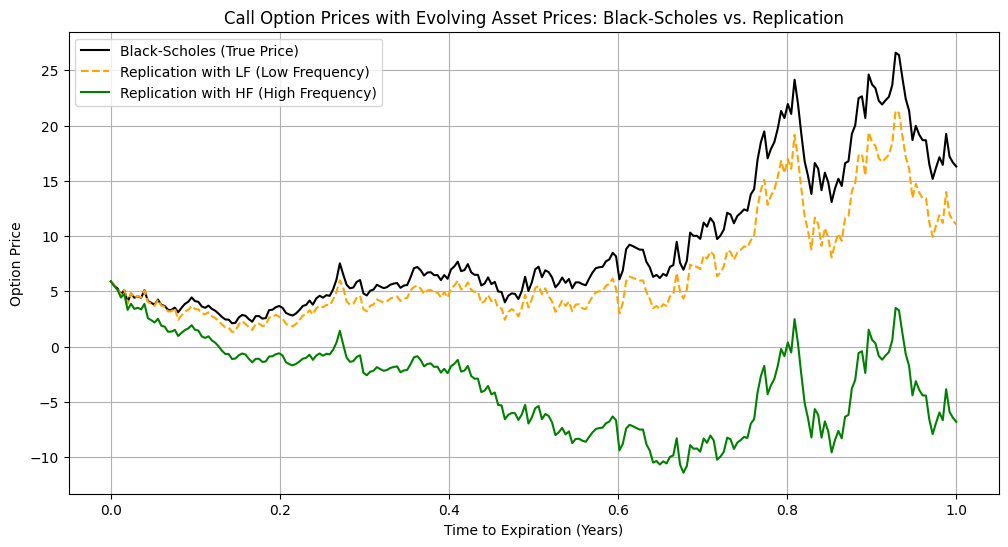

In [8]:
t = np.linspace(0, T, n_steps)

plt.figure(figsize=(12, 6))
plt.plot(t, Call_price, label='Black-Scholes (True Price)', color='black')
plt.plot(t, V_with_cost_LF, label='Replication with LF (Low Frequency)', color='orange', linestyle='--')
plt.plot(t, V_with_cost_HF, label='Replication with HF (High Frequency)', color='green')

plt.title('Call Option Prices with Evolving Asset Prices: Black-Scholes vs. Replication')
plt.xlabel('Time to Expiration (Years)')
plt.ylabel('Option Price')

plt.legend()
plt.grid()
plt.show()

## Call replication with transaction cost and leland correction

In [11]:
Call_price_leland, V_with_cost_HF_leland, delta_with_cost_HF_leland = call_replication(asset = asset_,
                                                                                       S = S,
                                                                                       K = K,
                                                                                       bid_ask_spread = bid_ask_spread,
                                                                                       replication_frequency = 1,
                                                                                       with_cost = True,
                                                                                       leland_correction = True
                                                                                       )
Call_price_leland, V_with_cost_LF_leland, delta_with_cost_LF_leland = call_replication(asset = asset_,
                                                                                       S = S,
                                                                                       K = K,
                                                                                       bid_ask_spread = bid_ask_spread,
                                                                                       replication_frequency = 10,
                                                                                       with_cost = True,
                                                                                       leland_correction = True
                                                                                       )

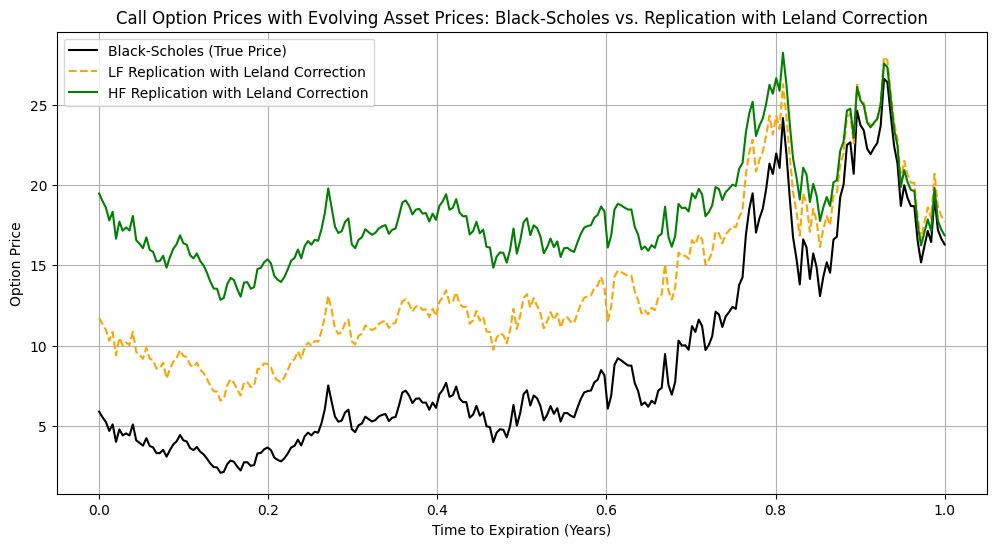

In [12]:
t = np.linspace(0, T, n_steps)

plt.figure(figsize=(12, 6))
plt.plot(t, Call_price, label='Black-Scholes (True Price)', color='black')
plt.plot(t, V_with_cost_LF_leland, label='LF Replication with Leland Correction', color='orange', linestyle='--')
plt.plot(t, V_with_cost_HF_leland, label='HF Replication with Leland Correction', color='green')

plt.title('Call Option Prices with Evolving Asset Prices: Black-Scholes vs. Replication with Leland Correction')
plt.xlabel('Time to Expiration (Years)')
plt.ylabel('Option Price')

plt.legend()
plt.grid()
plt.show()

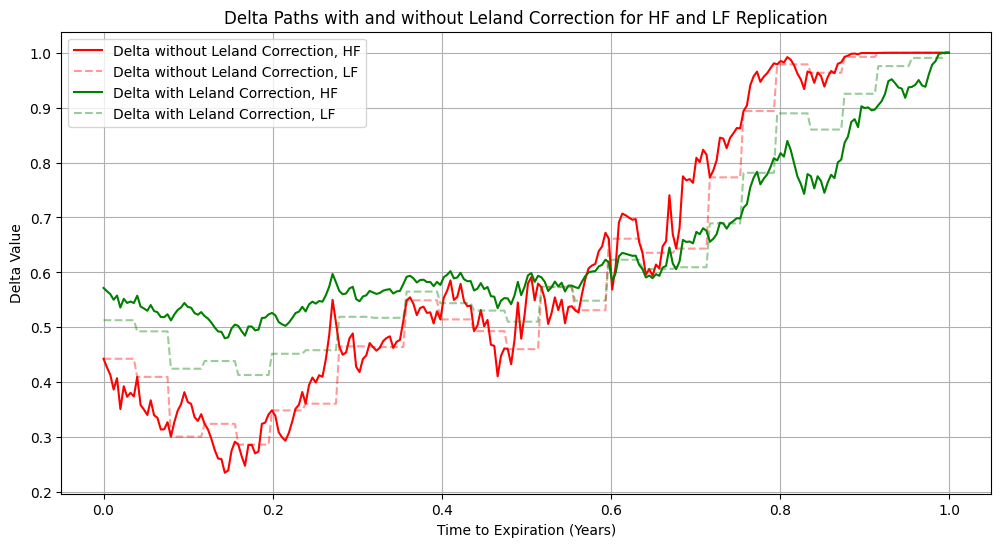

In [13]:
t = np.linspace(0, T, n_steps)

plt.figure(figsize=(12, 6))

plt.plot(t, delta_with_cost_HF, label='Delta without Leland Correction, HF', color='red')
plt.plot(t, delta_with_cost_LF, label='Delta without Leland Correction, LF', color='red', linestyle='--', alpha=0.4)

plt.plot(t, delta_with_cost_HF_leland, label='Delta with Leland Correction, HF', color='green')
plt.plot(t, delta_with_cost_LF_leland, label='Delta with Leland Correction, LF', color='green', linestyle='--', alpha=0.4)

plt.title('Delta Paths with and without Leland Correction for HF and LF Replication')
plt.xlabel('Time to Expiration (Years)')
plt.ylabel('Delta Value')
plt.legend()
plt.grid()
plt.show()